<a href="https://colab.research.google.com/github/pmilks/cap-comp215/blob/main/STAT305_Step_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#HURDAT Parsing -> Hurricane Objects w/ list of Entry objects
from dataclasses import dataclass
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

@dataclass
class Hurricane():
    name: str
    entries: list
    year: str
    basin: str
    atfc: int

    def __str__(self):
        return f'Storm {self.name} in {self.year} with {len(self.entries)} entries.'

    @classmethod
    def from_splt_hur(cls,splt_hur):
        splt_hur_head=[i.strip(' ') for i in splt_hur[0].split(',')]
        new = Hurricane(name=splt_hur_head[1],
                        year=int(splt_hur_head[0][-4:]),
                        basin=splt_hur_head[0][:2],
                        atfc=splt_hur_head[0][-6:-4],
                        entries=[])
        new.entries=Entry.entries_factory(splt_hur[1:])
        return new

    def total_max_wind(self):
        max=0
        for entry in self.entries:
            if entry.max_wind > max:
                max = entry.max_wind
        return max

    def max_min_pressure(self):
        max=0
        for entry in self.entries:
            if entry.min_pressure > max:
                max = entry.min_pressure
        return max

    def max_radius(self):
        max=0
        for entry in self.entries:
            if entry.radius > max:
                max = entry.radius
        return max

@dataclass
class Entry():
    date: datetime
    identifier: str
    status: str
    coordinates: tuple
    max_wind: int
    min_pressure: int
    radius: int

    def __str__(self):
        return f'{self.date} at {self.coordinates}\nID: {self.identifier}, Status: {self.status}\nMax Wind: {self.max_wind}, Min Pressure: {self.min_pressure}, Radius: {self.radius}'

    @classmethod
    def Factory(cls, entry):
        return Entry(date=datetime.strptime(f"{entry[0]}{entry[1]}",'%Y%m%d%H%M'),
                    identifier=entry[2],
                    status=entry[3],
                    coordinates=(entry[4], entry[5]),
                    max_wind=int(entry[6]),
                    min_pressure=int(entry[7]),
                    radius=int(entry[20]))

    @classmethod
    def entries_factory(cls,raw_entries):
        entries=[]
        for entry in raw_entries:
            entry_splt=[i.strip(' ') for i in entry.split(',')]
            entries.append(Entry.Factory(entry_splt))
        return entries

splt_hurricanes_raw=[]
with open("hurdat1923_2023.txt","r") as f:
    hur=[]
    for line in f:
        if line[0].isalpha():
            if hur != []:
                splt_hurricanes_raw.append(hur)
                hur=[]
        hur.append(line.strip())

hurricanes_classed=[]
for i in splt_hurricanes_raw:
    hurricanes_classed.append(Hurricane.from_splt_hur(i))

<ipython-input-6-39ec63525b95>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_hurct_1965 = df[df['Year']>=1965][df['Year']<=2017]['Year']


[('DR', 0.27648286447793424), ('SE CUBA', 0.28699652583287316), ('GULF', 0.2727980788565393), ('E MIAMI', 0.23418100519895257), ('E SC', -0.48822848105381217)]


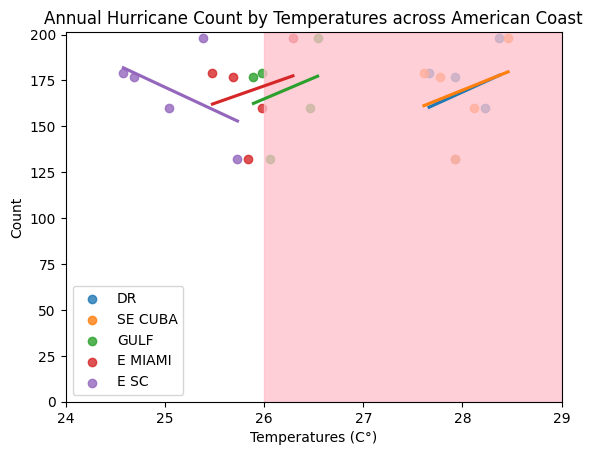

In [6]:
#Visualization of corr/regres of temperatures & hurricane count
#Create dataframe from listed hurricane classes
df_data = [ [hur.name, hur.year, hur.total_max_wind(), hur.max_min_pressure(), hur.max_radius()] for hur in hurricanes_classed]
df = pd.DataFrame(df_data, columns=['Name','Year','Max Wind', 'Max Pressure', 'Max Radius'])

df_hurct_1965 = df[df['Year']>=1965][df['Year']<=2017]['Year']
bins=[1965,1975,1985,1995,2005,2017]
df_hurct_1965_bin=pd.cut(df_hurct_1965,bins,right=False).value_counts().sort_index()

df_hurct_1965_bin=pd.DataFrame(data={'Year':['1965-1974','1975-1984','1985-1994','1995-2004','2005-2017'],
                                    'Count':[179,177,132,160,198]})

df_hur_temp = pd.merge(df_hurct_1965_bin,pd.read_csv('oceanic_temps.csv'),on='Year')
regression = []
for region in ['DR','SE CUBA','GULF','E MIAMI','E SC']:
    regression.append((region,df_hur_temp[[region,'Count']].corr().iloc[0,1]))
    sns.regplot(x=region, y="Count", data=df_hur_temp,label=region,ci=None)
print(regression)
plt.legend()
plt.title('Annual Hurricane Count by Temperatures across American Coast')
plt.xlabel('Temperatures (C°)')
plt.axvspan(26, 30,
            color ='pink',
            alpha = 0.75)
plt.xlim(24,29)
plt.ylim(0,)
plt.show()

<ipython-input-9-a0db1337c1de>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_hurct_1992 = df[df['Year']>=1992][df['Year']<=2022][['Year','Max Pressure','Max Wind']]


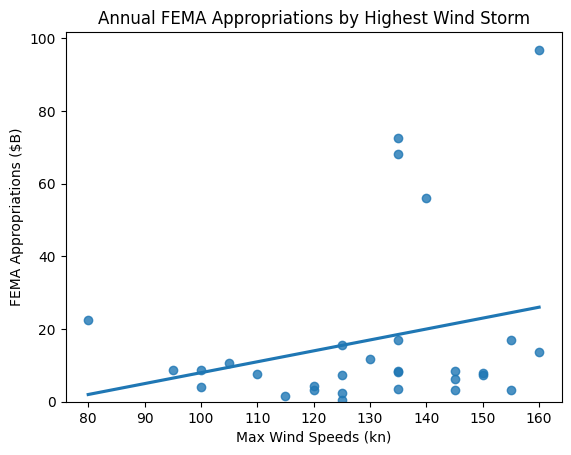

In [9]:
#Create pandas dataframe for damage, wind, pressure & year
df_hurct_1992 = df[df['Year']>=1992][df['Year']<=2022][['Year','Max Pressure','Max Wind']]
df_hurct_1992_max = pd.DataFrame(data={'Year':[str(i) for i in range(1992,2022)]})

maxes = {'Year':[],'Max Wind':[],'Max Pressure':[]}
for i in range(1992,2022):
    maxes['Year'].append(i)
    maxes['Max Pressure'].append(df_hurct_1992[df_hurct_1992['Year']==i].max()['Max Pressure'])
    maxes['Max Wind'].append(df_hurct_1992[df_hurct_1992['Year']==i].max()['Max Wind'])
df_maxes = pd.DataFrame(maxes)
df_maxes = pd.merge(df_maxes,pd.read_csv('FEMA_appropriations.csv')[['Year','Annual Appropriations']],on='Year')

#Visualization of corr/regres of Max Wind
regression = []
sns.regplot(x='Max Wind', y="Annual Appropriations", data=df_maxes,ci=None)
regression.append('Max Wind: ' + str(df_maxes[['Max Wind','Annual Appropriations']].corr().iloc[0,1]))
plt.title('Annual FEMA Appropriations by Highest Wind Storm')
plt.ylabel('FEMA Appropriations ($B)')
plt.xlabel('Max Wind Speeds (kn)')
plt.ylim(0,)
plt.show()

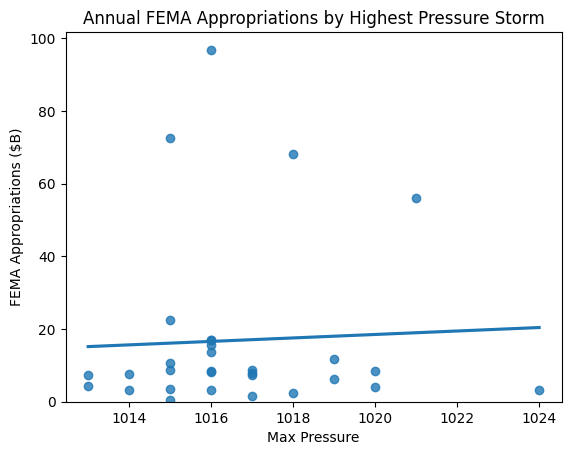

['Max Wind: 0.255785715958885', 'Max Pressure: 0.048774304721655656']


In [10]:
#Visualization of corr/regres of Max Pressure
sns.regplot(x='Max Pressure', y="Annual Appropriations", data=df_maxes,ci=None)
regression.append('Max Pressure: ' + str(df_maxes[['Max Pressure','Annual Appropriations']].corr().iloc[0,1]))
plt.title('Annual FEMA Appropriations by Highest Pressure Storm')
plt.ylabel('FEMA Appropriations ($B)')
plt.xlabel('Max Pressure')
plt.ylim(0,)
plt.show()

print(regression)